In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import elevation
import elevation.prediction_pipeline as pp
import elevation.aggregation
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
np.random.seed(123) 
import scipy.stats as st
import pickle
#import seaborn
import matplotlib
import azimuth.util
import sklearn
import copy

/home/nicolo/anaconda3/envs/elevation/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nicolo/anaconda3/envs/elevation/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/nicolo/anaconda3/envs/elevation/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tser

In [2]:
MAX_VALUE_JOHN = 1000

# Gecko analysis

In [3]:
# with open('/mnt/nerds5_genetics/CRISPR.offtarget/gecko_new.calib1_ctnm1.3MM.v10.N9919088_groupby_nonagg_small.p', 'rb') as f:
#    results_gecko = pickle.load(f)# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko.calib0_countnormTrue.v7.gbrtw1.00e+02.N3137128_groupby_nonagg_small.p', 'rb') as f:


#with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko, 'rb') as f:
# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko_allmodels_calib0_countnormTrue.N3137128_groupby_nonagg.p', 'rb') as f:
#    results_gecko_v6 = pickle.load(f)

# New version use this
with open('/mnt/nerds5_compbio_storage/CRISPR.offtarget/forNicolo/process_michael_output_renorm.6.27.2017/gecko_new.calib1_ctnm1..GSGR1.boxcox1.N9919088_groupby_nonagg_small.local2.p', 'rb') as f:
    results_gecko = pickle.load(f)


mit_gecko = pd.read_excel('../../../data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_complete.xls')
mit_gecko = mit_gecko[['offtarget_score', 'sgRNA measured value', 'sgRNA Sequence']].dropna()
st.spearmanr(mit_gecko['offtarget_score'], mit_gecko['sgRNA measured value'])

SpearmanrResult(correlation=-0.03679095170337926, pvalue=0.011698833031457448)

In [4]:
gecko_data = pd.read_csv('../../../data/offtarget/3MM_michael/GeCKOv2_Non_essentials_Achilles_A375.txt', delimiter='\t')
gecko_data['full_seq'] = gecko_data['sgRNA context sequence'].apply(lambda x: x[4:20+4+3])
gecko_data['A375 Percent rank'] = gecko_data['sgRNA measured value']
gecko_merged = pd.merge(gecko_data, mit_gecko, left_on='sgRNA Sequence', right_on='sgRNA Sequence')

In [5]:
jd_gecko = pd.read_excel('../../../data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_updated.xls')
#jd_gecko['full_seq'] = jd['sgRNA Sequence'] + jd['PAM Sequence']
# jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average', 'full_seq']].set_index(['full_seq'])
# jd = jd.loc[jd['T1 MB12'] != 'MAX']
jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average']].replace([np.inf, -np.inf], MAX_VALUE_JOHN).dropna()
print gecko_merged.shape
print jd_gecko.shape
gecko_merged = pd.merge(gecko_merged, jd_gecko, on=['sgRNA Sequence'])
print gecko_merged.shape

(4695, 29)
(4039, 2)
(4039, 30)


In [6]:
st.spearmanr(gecko_merged['Broad_John_bin_average'], gecko_merged['A375 Percent rank'])

SpearmanrResult(correlation=-0.014222054015991881, pvalue=0.36619590351459275)

# Avana analysis

In [7]:
import sklearn.neighbors.kde as kde
import sklearn.grid_search as gs 
def kde_cv_and_fit(data, bandwidth_range=np.linspace(0.01, 2., 100)):
    grid = gs.GridSearchCV(kde.KernelDensity(kernel='gaussian', rtol=1e-7),
                    {'bandwidth': bandwidth_range},
                    cv=10, refit=True, n_jobs=20, verbose=1)
    grid.fit(data[:, None])
    print grid.best_params_
    kd = grid.best_estimator_
    log_pdf = kd.score_samples(data[:, None])
    return np.exp(log_pdf), kd


In [8]:
# New version use this
with open('/mnt/nerds5_compbio_storage/CRISPR.offtarget/forNicolo/process_michael_output_renorm.6.27.2017/avana_new.calib1_ctnm1..GSGR1.boxcox1.N15245690_groupby_nonagg_small.local2.p', 'rb') as f:
    results = pickle.load(f)


In [9]:
mit_avana = pd.read_excel('../../../data/offtarget/Non-Essentials_Avana_done.xlsx')
mit_avana['full_seq'] = mit_avana['sgRNA Target Sequence'] + mit_avana['PAM Sequence']
#mit_avana = mit_avana[['offtarget_score', 'A375 Percent rank', 'sgRNA Target Sequence']].dropna()
print mit_avana.shape

(4950, 17)


In [10]:
jd = pd.read_excel('../../../data/offtarget/Non-Essentials_Avana_updated.xlsx')
jd['full_seq'] = jd['sgRNA Target Sequence'] + jd['PAM Sequence']
jd = jd.set_index(['full_seq'])
# jd = jd.loc[jd['T1 MB12'] != 'MAX']
jd = jd.replace([np.inf, -np.inf], MAX_VALUE_JOHN).dropna()
print mit_avana.shape
mit_avana = pd.merge(mit_avana, jd, on=['sgRNA Target Sequence', 'A375 Percent rank'])
print mit_avana.shape

(4950, 17)
(4944, 27)


In [11]:
def get_stats(data, genic):
    stats = []
    # percentiles = np.logspace(np.log10(0.9999), np.log10(0.001), 100)
    # percentiles = np.linspace(0.9999, 0.1, 10) * 100.
    # percentiles = np.linspace(1, 100, 100)
    
    # for percentile in percentiles:
    #     stats.append(np.percentile(data, percentile))
        
    # for percentile in percentiles:
    #     if genic.sum() == 0:
    #         stats.append(0.0)
    #     else:
    #         stats.append(np.percentile(data[genic], percentile))
        
    # for percentile in percentiles:
    #     if (~genic).sum() == 0:
    #         stats.append(0.0)
    #     else:
    #         stats.append(np.percentile(data[~genic], percentile))

    stats.append(np.std(data))
    stats.append(np.std(data[genic]))
    stats.append(np.std(data[~genic]))
    stats.append(np.var(data))
    stats.append(np.var(data[genic]))
    stats.append(np.var(data[~genic]))
    stats.append(np.mean(data))
    stats.append(np.mean(data[genic]))
    stats.append(np.mean(data[~genic]))
    stats.append(np.median(data))
    stats.append(np.median(data[genic]))
    stats.append(np.median(data[~genic]))
    stats.append(np.sum(genic))
    stats.append(np.sum(~genic))
    stats.append(np.sum(genic)/float(len(data)))
    stats.append(np.sum(~genic)/float(len(data)))
    stats.append(np.percentile(data, 99))
    stats.append(np.percentile(data[genic], 99))
    stats.append(np.percentile(data[~genic], 99))
    stats.append(np.percentile(data, 95))
    stats.append(np.percentile(data[genic], 95))
    stats.append(np.percentile(data[~genic], 95))
    stats.append(np.percentile(data, 90))
    stats.append(np.percentile(data[genic], 90))
    stats.append(np.percentile(data[~genic], 90))
    
    if (~genic).sum() == 0:
        stats.append(0.0)
    else:
        stats.append(np.sum(genic)/float(np.sum(~genic)))
        
    if (~genic).sum() == 0 or np.mean(data[~genic]) == 0:
        stats.append(0.0)
    else:
        stats.append(np.mean(data[genic])/np.mean(data[~genic]))
    stats.append(0)
    stats.append(0)
    stats.append(0)
    if np.any(np.isinf(stats)) or np.any(np.isnan(stats)):
        raise Exception
    return np.array(stats)

In [12]:
def train_big_model(X, y):
    param_grid = {'learning_rate': [0.01, 0.05, 0.1],
                    'max_depth': [1,2,3,4,5],
                     'loss': ['ls', 'lad' ],
                     'n_estimators': [10, 50, 75, 100, 120],
                  'max_features': ['auto', 'sqrt', 'log2']}

    est = sklearn.ensemble.GradientBoostingRegressor()#n_estimators=20, max_depth=1, loss='lad')
    final_model = GridSearchCV(est, param_grid, n_jobs=20, verbose=1, cv=5, 
                      scoring=azimuth.models.ensembles.spearman_scoring, iid=False)
    final_model.fit(X, y)
    return final_model

In [13]:
def aggregator_features(results, mit_results, N=None, methods=['product', 'CFD', 'linear-raw-stacker', 'MIT', 'ensemble', 'HsuZhang'], which='old'):
    truth = []
    broad = []
    mean = dict((m, []) for m in methods)
    score = dict((m, []) for m in methods)
    raw = dict((m, []) for m in methods)
    skipped = 0
    if N is None:
        N = min(len(results[1].keys()), mit_results.shape[0])
    # N = min(N, len(results[1].keys()), mit_results.shape[0])
    
    D = 30

    features = dict((m, np.zeros((N, D))) for m in methods) # 46, 18
    features['ensemble'] = np.zeros((N, D*2))
    if 'ensemble_1' in methods:
        features['ensemble_1'] = np.zeros((N, D))
    if 'ensemble_2' in methods:
        features['ensemble_2'] = np.zeros((N, D*2))
    if 'ensemble_3' in methods:
        features['ensemble_3'] = np.zeros((N, D*2))
    if 'ensemble_4' in methods:
        features['ensemble_4'] = np.zeros((N, D*3))

    guides = []
    # pdf = np.exp(kd.score_samples(Xgs[:, None]))
    i = 0
    #for g in results[1].keys():
    for g in mit_results['full_seq'].values:

        if i % 1000 == 0:
            print i, mit_results.shape[0]

        if not (g in results[0]['linear-raw-stacker'] and g in results[0]['CFD']):
            skipped += 1
            continue

        if i >= N:
            break

        try:
            for method in methods:
                if method == 'MIT':
                    mean[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                    score[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                elif method == 'broad':
                    score[method].append(-mit_results[mit_results['full_seq'] == g]['Broad_John_bin_average'].values[0])
                elif method == 'ensemble':
                    # just call old get_stats in aggregation with CFD stats back in, removing this for now
                    raise NotImplementedError
                elif method == 'final_model':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    features[method][i], names = elevation.aggregation.get_stats(np.array(results[0]['linear-raw-stacker'][g]), 
                                                                          np.array(results[0]['CFD'][g]), genic_g)
                elif method == 'ensemble_1':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 1)
                elif method == 'ensemble_2':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 2)
                elif method == 'ensemble_3':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 3)
                elif method == 'ensemble_4':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 4)
                elif method == 'HsuZhang':
                    t = np.array(results[0][method][g])
                    preds_g = t
                    score[method].append(100./(100 + np.sum(preds_g)))
                else:
                    t = np.array(results[0][method][g])
                    # if method == 'linear-raw-stacker':
                    #    a,b,c,d,f = [-0.40317539,  0.48128055,  0.6186926 ,  0.14710948,  0.78741327]

                    #    # avana = [ 1.26015589, -0.01607083,  4.17914254,  0.39207014, -0.30867801]
                    #    t =  a + b*t + c*np.tanh(d*t + f)
                    #    # print "WARNING: warping based on Avana values"
                    preds_g = t
                    genic_g = np.array(results[1][g]) != 'NoGene' 

                    mean[method].append(np.mean(preds_g[genic_g]))
                    score[method].append(np.sum(preds_g[genic_g])/float(len(preds_g)))


                    if which == 'old':
                        features[method][i] = get_stats(preds_g, genic_g)
                    elif which == 'new':
                        features[method][i] = get_stats(preds_g, genic_g)
                    else:
                        sorted_bo = np.sort(preds_g)
                        yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))
                        features[method][i] = yvals_bo[np.logspace(np.log10(2), np.log10(len(yvals_bo)), 50, dtype=int)-1]

                    raw[method].append((preds_g, genic_g))

                    # reference_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmin()].full_seq
                    # reference_offtargets = np.array(results[0][method][reference_guide])
                    # genic_reference = np.array(results[1][reference_guide]) != 'NoGene'
                    #bad_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmax()].full_seq
                    #bad_offtargets = np.array(results[0][method][bad_guide]
                    sorted_bo = np.sort(preds_g)
                    yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))

                    # try:
                    #    mean['KS2_%s'% method].append(st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1])
                    #    mean['AUC_%s' % method].append(sklearn.metrics.auc(sorted_bo, yvals_bo))
                    #except KeyError:
                    #    mean['KS2_%s'% method] = [st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1]]
                    #    mean['AUC_%s' % method] = [sklearn.metrics.auc(sorted_bo, yvals_bo)]

            i+=1
            truth.append(mit_results[mit_results['full_seq'] == g]['A375 Percent rank'].values[0])
            guides.append(g)

        except KeyError as e:
            # print type(e), e
            # print "skipping guide: ", g
            skipped += 1
            #continue
            
    for method in mean.keys():
        mean[method] = np.array(mean[method])
        
    for method in score.keys():
        score[method] = np.array(score[method])
    print "skipped %d guides" % skipped
    return features, truth, mean, score,  guides


In [14]:
def generate_random_sample(N, how_many=100):
    all_perm = {}
    for i in range(how_many):
        all_perm[str(i)] = np.random.permutation(N)
    return all_perm
    

In [14]:
features, truth, mean, score, guides = aggregator_features(results, mit_avana, which='new', N=4543,
                                                           methods=['broad', 'MIT', 'final_model'])
                                                                #methods=['product', 'CFD', 'linear-raw-stacker', 
                                                                  #       'MIT', 'ensemble', 'broad', 'HsuZhang'])
y_rank = st.mstats.rankdata(truth)/float(len(truth))

0 4944
0 4944
1000 4944
2000 4944
3000 4944
4000 4944
skipped 401 guides


In [15]:
features_gecko, truth_gecko, mean_gecko, score_gecko, guides_gecko = aggregator_features(results_gecko, gecko_merged, N=3890, 
                                                                           which='new',
                                                                                         methods=['broad', 'MIT', 'final_model'])
                                                                          #        methods=['product', 'CFD', 'linear-raw-stacker', 
                                                                         #'MIT', 'ensemble', 'broad', 'HsuZhang'])
y_gecko_rank = st.mstats.rankdata(truth_gecko)/float(len(truth_gecko))

0 4039
1000 4039
2000 4039
3000 4039
skipped 149 guides


In [62]:
features_tmp.keys()

['final_model', 'broad', 'ensemble', 'MIT']

In [63]:
loss = ['ls', 'lad', 'huber']
learning_rate = np.linspace(1e-6, 1., 100)
n_estimators = [20, 50, 80, 100, 200, 300, 400, 500]
max_depth = [1, 2, 3, 4, 5, 6, 7]
criterion = ['friedman_mse', 'mse', 'mae']
min_samples_split = [2,3,4]
all_res = []
for i in range(200):
    options = {
        'loss': np.random.permutation(loss)[0],
        'learning_rate': np.random.permutation(learning_rate)[0],
        'n_estimators': np.random.permutation(n_estimators)[0],
        'max_depth': np.random.permutation(max_depth)[0],
        'criterion': np.random.permutation(criterion)[0],
        'min_samples_split': np.random.permutation(min_samples_split)[0],
    }
    feat = features_tmp['final_model']
    feat_gecko = features_gecko_tmp['final_model']
    
    #final_model = elevation.aggregation.train_model(feat, y_rank)
    final_model = sklearn.ensemble.GradientBoostingRegressor(**options)
    final_model.fit(feat, y_rank)
    preds_gecko = final_model.predict(feat_gecko)

    final_model = sklearn.ensemble.GradientBoostingRegressor(**options)
    final_model_gecko = final_model.fit(feat_gecko, y_gecko_rank)
    # final_model_gecko = elevation.aggregation.train_model(feat_gecko, y_gecko_rank)
    preds_avana = final_model_gecko.predict(feat)
    random_res = {}
    random_res['options'] = options
    random_res['gecko'] = st.spearmanr(preds_gecko, y_gecko_rank)[0]
    random_res['avana'] = st.spearmanr(preds_avana, y_rank)[0]
    all_res.append(random_res)
    print random_res

{'avana': 0.19765390140767561, 'gecko': 0.10182009930356878, 'options': {'loss': 'lad', 'learning_rate': 0.10101099999999999, 'n_estimators': 300, 'criterion': 'mse', 'min_samples_split': 3, 'max_depth': 3}}
{'avana': 0.18727898497742584, 'gecko': 0.086155674594606976, 'options': {'loss': 'lad', 'learning_rate': 0.73737399999999997, 'n_estimators': 200, 'criterion': 'mse', 'min_samples_split': 4, 'max_depth': 1}}
{'avana': 0.17686289622697263, 'gecko': 0.098951136417451874, 'options': {'loss': 'lad', 'learning_rate': 0.050505999999999995, 'n_estimators': 500, 'criterion': 'mse', 'min_samples_split': 2, 'max_depth': 6}}
{'avana': 0.18421993157584199, 'gecko': 0.09463139354277636, 'options': {'loss': 'huber', 'learning_rate': 0.060606999999999994, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 3, 'max_depth': 5}}
{'avana': 0.23561252384785997, 'gecko': 0.096968014855430884, 'options': {'loss': 'huber', 'learning_rate': 0.060606999999999994, 'n_estimators': 50, 'criterion':

KeyboardInterrupt: 

In [65]:
st.spearmanr(preds_gecko, y_gecko_rank)

SpearmanrResult(correlation=0.10509974061990199, pvalue=4.9926364448834447e-11)

In [ ]:
st.spearmanr(preds_gecko, y_gecko_rank)

In [71]:
preds_gecko = {}
preds_avana = {}

features_gecko_tmp = copy.deepcopy(features_gecko)
features_tmp = copy.deepcopy(features)
# features_tmp['ensemble'] = np.concatenate((features['linear-raw-stacker'], features['CFD']), axis=1)
# features_gecko_tmp['ensemble'] = np.concatenate((features_gecko['linear-raw-stacker'], features_gecko['CFD']), axis=1)
#model_options = {'loss': 'lad', 'learning_rate': 0.17171799999999998, 'n_estimators': 100, 'criterion': 'mae', 'min_samples_split': 4, 'max_depth': 1}
model_options = {'loss': 'ls', 'learning_rate': 0.12121299999999999, 'n_estimators': 20, 'criterion': 'mae', 'min_samples_split': 3, 'max_depth': 3}

for m in features_gecko_tmp.keys():
    if m == 'MIT':
        preds_gecko[m] = mean_gecko[m]
        preds_avana[m] = mean[m]
    elif m == 'broad':
        preds_gecko[m] = score_gecko[m]
        preds_avana[m] = score[m]   
    elif m == 'HsuZhang':
        preds_gecko[m] = score_gecko[m]
        preds_avana[m] = score[m]  
    elif m == 'final_model':
        print "ENTERED!!"
        feat = features_tmp[m]
        feat_gecko = features_gecko_tmp[m]
            
        final_model_avana = elevation.aggregation.train_model(feat, y_rank)
        # final_model = sklearn.linear_model.LassoCV(cv=20)
        # final_model.fit(features[m], np.array(truth))
        #final_model_avana = sklearn.ensemble.GradientBoostingRegressor(**model_options)
        #final_model_avana.fit(feat, y_rank)
        # final_model = train_big_model(feat, y_rank)
        preds_gecko[m] = final_model_avana.predict(feat_gecko)
        
        # final_model_gecko = sklearn.ensemble.GradientBoostingRegressor(**model_options)
        #final_model_gecko.fit(feat_gecko, y_gecko_rank)
        # final_model = train_big_model(feat_gecko, y_gecko_rank)
        final_model_gecko = elevation.aggregation.train_model(feat_gecko, y_gecko_rank)
        preds_avana[m] = final_model_gecko.predict(feat)
    else:
        print "ignoring ", m

ENTERED!!
ignoring  ensemble


In [41]:
print features_gecko_tmp['final_model'].shape
print features_tmp['final_model'].shape

(3890, 30)
(4543, 30)


In [43]:
final_model_avana.predict(features_gecko_tmp['final_model'])

array([ 0.65361692,  0.59804501,  0.54257669, ...,  0.63979608,
        0.28838403,  0.63622046])

In [72]:
def convert_to_dict(preds, guide_names):
    methods_preds_dict = {}

    for method in preds.keys():
        preds_dict = {}
        # print len(guide_names), len(preds[method])
        assert len(guide_names) == len(preds[method])
        for i in range(len(guide_names)):
            preds_dict[guide_names[i]] = preds[method][i]
        methods_preds_dict[method] = preds_dict
    return methods_preds_dict

def fill_max_vals(preds_dict, df):
    final_results = {}

    for method in preds_dict.keys():
        truth = []
        final_results[method] = []
        for g in df['full_seq'].values:
            truth.append(df[df['full_seq'] == g]['A375 Percent rank'].values[0])
            if method == 'broad':
                val = -df[df['full_seq'] == g]['Broad_John_bin_average'].values[0]
                final_results[method].append(val)
            elif method == 'MIT':
                val = df[df['full_seq'] == g]['offtarget_score'].values[0]
                final_results[method].append(val)
            else:
                if g in preds_dict[method].keys():
                    final_results[method].append(preds_dict[method][g])
                else:
                    final_results[method].append(MAX_VALUE_JOHN)
        final_results[method] = np.array(final_results[method])      
    final_results['MIT'][np.isnan(final_results['MIT'])] = 0
    truth = st.mstats.rankdata(truth)/float(len(truth))
    return final_results, truth

gecko_preds_dict = convert_to_dict(preds_gecko, guides_gecko)
avana_preds_dict = convert_to_dict(preds_avana, guides)
final_results_avana, truth_avana = fill_max_vals(avana_preds_dict, mit_avana)
final_results_gecko, truth_gecko = fill_max_vals(gecko_preds_dict, gecko_merged)   

In [75]:
# final_model_avana = elevation.aggregation.train_model(features['ensemble'], y_rank)
with open('aggregation_results.pickle', 'wb') as f:
    pickle.dump(([final_results_gecko, np.array(truth_gecko)],[final_results_avana, np.array(truth_avana)]), f)
with open('aggregation_model.pkl', 'wb') as f:
    pickle.dump((final_model_avana, None), f)
with open('aggregation_test.pkl', 'wb') as f:
    pickle.dump((features_gecko_tmp['final_model'], final_model_avana.predict(features_gecko_tmp['final_model'])), f)

In [18]:
us = st.spearmanr(final_results_gecko['ensemble'], truth_gecko)[0]
broad = st.spearmanr(final_results_gecko['broad'], truth_gecko)[0]
print us, broad
print (us-broad)/broad

KeyError: 'ensemble'

In [58]:
us = st.spearmanr(final_results_gecko['ensemble'], truth_gecko)[0]
broad = st.spearmanr(final_results_gecko['broad'], truth_gecko)[0]
print us, broad
print (us-broad)/broad

0.0845656700492 0.014222054016
4.94609399979


broad
final_model
MIT


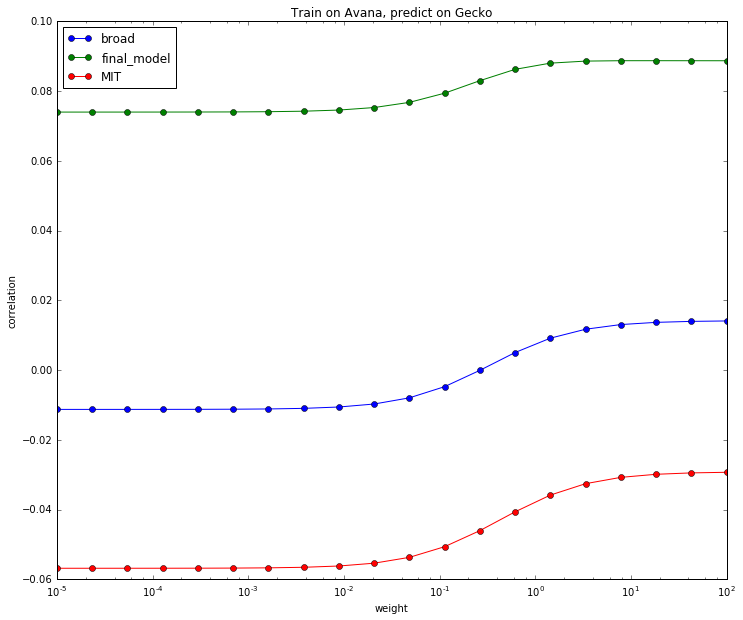

In [73]:
#preds_gecko['broad'] = score_gecko['broad']
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(final_results_gecko, np.array(truth_gecko), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
plt.title("Train on Avana, predict on Gecko")
#plt.ylim((-0.10, 0.15))

broad
final_model
MIT


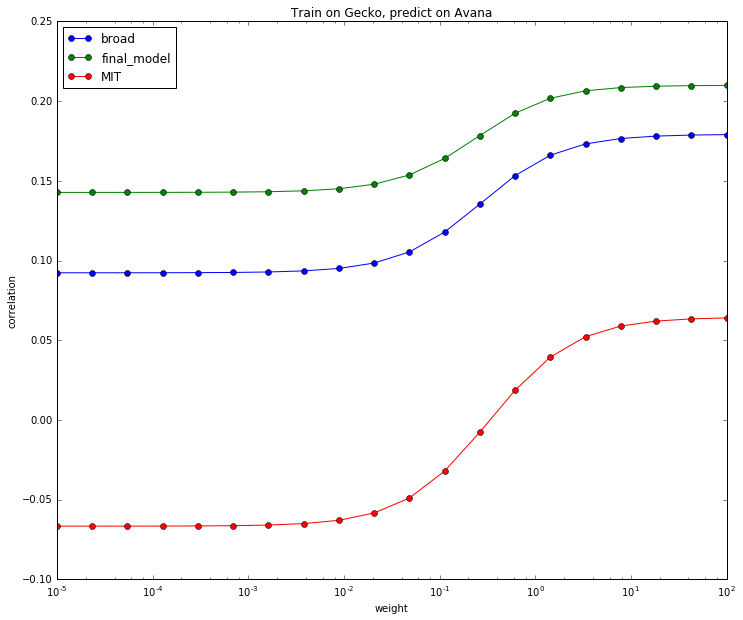

In [74]:

# preds_avana['broad'] = -score['broad']
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(final_results_avana, np.array(truth_avana), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
plt.title("Train on Gecko, predict on Avana")

product
HsuZhang
broad
CFD
MIT
linear-raw-stacker
ensemble


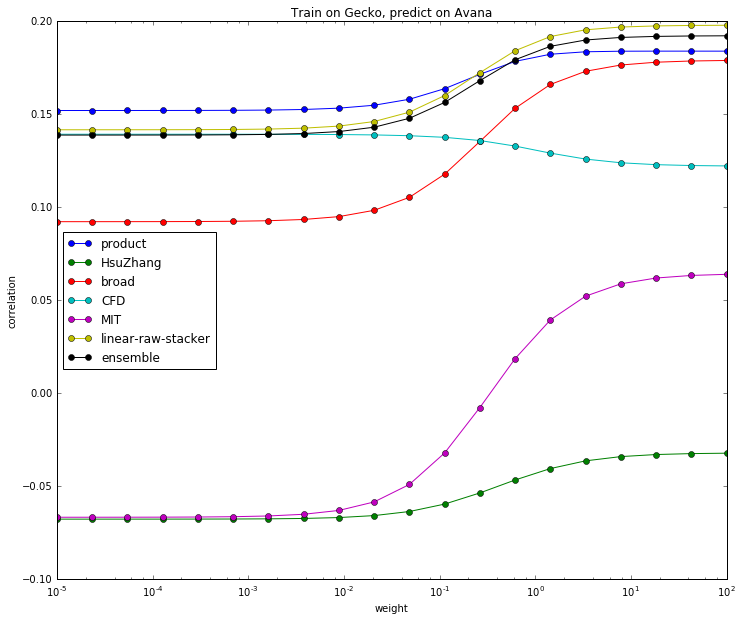

In [66]:

# preds_avana['broad'] = -score['broad']
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(final_results_avana, np.array(truth_avana), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
plt.title("Train on Gecko, predict on Avana")

In [49]:

def plot_spearman_different_num_zeros(pred, truth, models, my_title):

    frac_zeros_to_keep = np.arange(0, 1.1, 0.1)
    all_rr = np.nan*np.zeros((len(models), len(frac_zeros_to_keep)))
    # truth = data_to_predict_on['GUIDE-SEQ Reads']
    M = len(truth)
    non_zero_ind = np.where((truth > 0))[0]
    truth_non_zeros = truth[non_zero_ind]
    assert  np.all(truth_non_zeros > 0)
    zero_ind = np.where((truth == 0))[0]
    for i, fz in enumerate(frac_zeros_to_keep):
        tmp_zeros_ind = np.random.permutation(zero_ind)[0:np.round(fz*M)]
        for j, m in enumerate(models):            
            truth_zeros = truth[tmp_zeros_ind]
            assert  np.all(truth_zeros==0)
            ground_truth_tmp = np.concatenate((truth_non_zeros, truth_zeros), 0)
            #assert np.allclose(np.sum(ground_truth_tmp), np.sum(truth))
            preds_method = pred[m]    
            preds_tmp = np.concatenate((preds_method[non_zero_ind], preds_method[tmp_zeros_ind]),0)
            tmp, _garb = st.spearmanr(ground_truth_tmp, preds_tmp)
            all_rr[j, i] = tmp
            print "i=%d, j=%d, model=%s, fz=%f, r=%f" % (i, j, m, fz, tmp)
    
    plt.figure()
    for j, m in enumerate(models): plt.plot(frac_zeros_to_keep, all_rr[j,:], '-o', label=m)
    plt.legend(loc=0)
    plt.title(my_title)
    plt.ylabel("spearman correlation")
    plt.xlabel("fraction of zeros used")
    plt.grid('on')
    plt.show()

    plt.figure()
    for j, m in enumerate(models):                    
        cctop = all_rr[np.where(np.array(models)=="CCTOP")[0][0],:]
        plt.plot(frac_zeros_to_keep, (all_rr[j,:]-cctop)/cctop*100, '-o', label=m)
    plt.legend(loc=0)
    plt.title(my_title)
    plt.ylabel("% spearman correlation improvement over CCTOP")
    plt.xlabel("fraction of zeros used")
    plt.grid('on')
    plt.show()

    return all_rr, frac_zeros_to_keep

In [63]:

# preds_avana['broad'] = -score['broad']
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(final_results_avana, np.array(y_rank), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(20), 20))
plt.xscale('log')
plt.title("Train on Gecko, predict on Avana")

product


AssertionError: must have same shape

CFD
product
ensemble
linear-raw-stacker
MIT


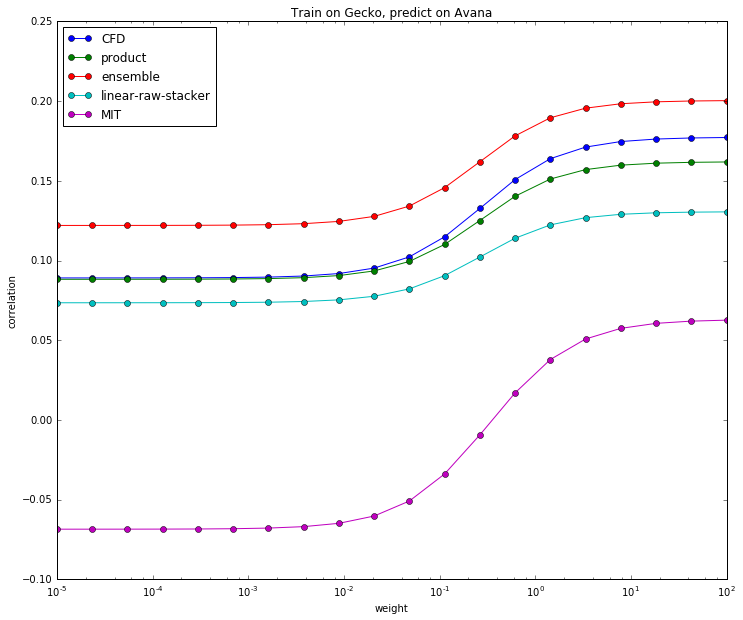

In [43]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds_avana, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
plt.title("Train on Gecko, predict on Avana")

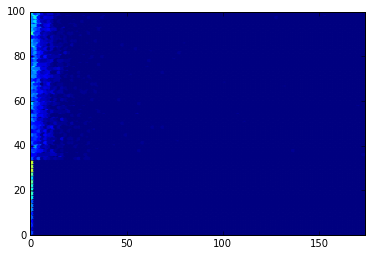

In [310]:
pred = jd['Broad_John_bin_average'].values
truth = jd['A375 Percent rank'].values
#plt.figure()
#plt.plot(pred, truth, 'o', alpha=.4)
#st.spearmanr(pred, truth)
plt.hexbin(pred, truth)

In [46]:
truth_gecko

[0.60546074999999999,
 0.71742899999999998,
 -0.10015800000000001,
 -0.64038450000000002,
 0.22851999999999997,
 1.4316822499999999,
 -1.2850219999999999,
 -0.089103000000000002,
 1.3950579999999999,
 0.28713899999999998,
 0.59418599999999999,
 0.026410000000000003,
 0.095078499999999996,
 0.51338600000000001,
 0.98267199999999999,
 0.21669674999999999,
 0.87539275000000005,
 0.55469899999999994,
 0.57735524999999999,
 0.27345150000000001,
 0.39431975000000002,
 1.0465867499999999,
 1.05598825,
 -0.63279775000000005,
 -0.57319200000000003,
 -0.57293249999999996,
 0.095043499999999989,
 0.52688250000000003,
 -0.10183925000000001,
 -0.32860175000000003,
 -0.74844325,
 -1.302181,
 -0.52847325000000001,
 -0.83223424999999995,
 -0.146289,
 -0.68142524999999998,
 0.72777000000000003,
 0.13413975,
 -0.68483574999999997,
 -0.23592925000000001,
 0.98088224999999996,
 0.033089500000000001,
 0.93328875,
 0.10564575,
 -0.55893199999999998,
 0.78618025000000002,
 0.77089200000000002,
 0.84271775000

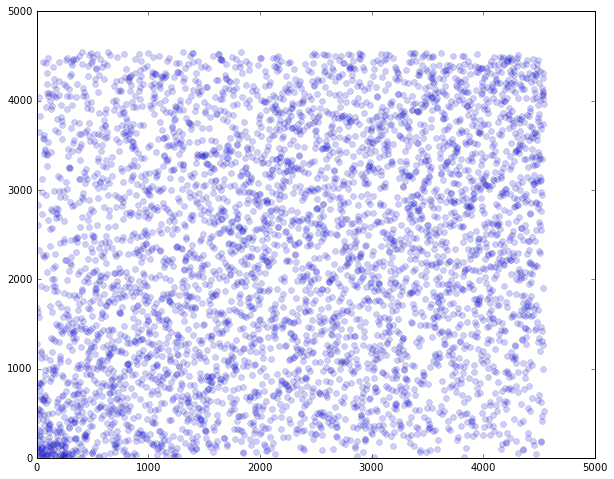

In [30]:
plt.figure(figsize=(10, 8))
plt.plot(st.rankdata(preds_avana['ensemble'].flatten()), st.rankdata(y_rank), 'o', alpha=.2)
# plt.hexbin(st.rankdata(preds_avana['ensemble'].flatten()), st.rankdata(y_rank))

CFD
product
ensemble
linear-raw-stacker
MIT


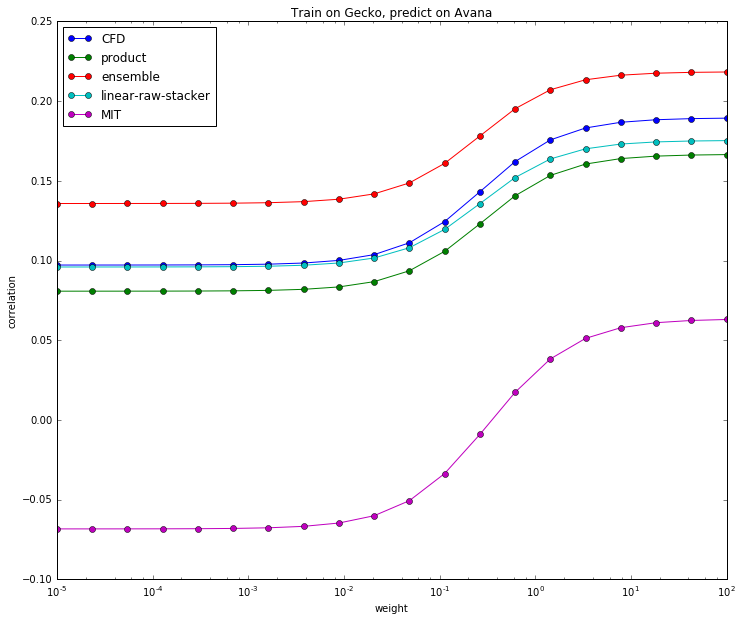

In [696]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds_avana, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
plt.title("Train on Gecko, predict on Avana")

In [278]:
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.linear_model
from sklearn.grid_search import GridSearchCV
#y = np.array(truth)
#y_rank = st.mstats.rankdata(y)/float(len(y))
kf = sklearn.cross_validation.KFold(y_rank.shape[0], n_folds=20)


preds = dict((m, np.zeros_like(y_rank)) for m in features.keys())

for i, split in enumerate(kf):
    train, test = split
    for method in features.keys():

        if method == 'MIT' or method == 'broad':
            preds[method][test] = -score[method][test]
        else:
            feat = features[method]
            final_model = elevation.aggregation.train_model(feat[train], y_rank[train])
            preds[method][test] = final_model.predict(feat[test])

    print i




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


product
broad
CFD
MIT
linear-raw-stacker
ensemble


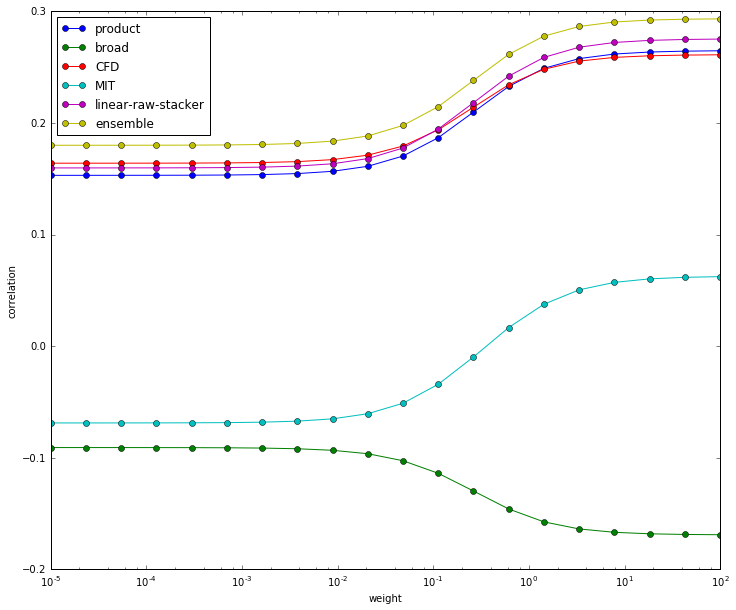

In [277]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')

CFD
product
ensemble
linear-raw-stacker
MIT


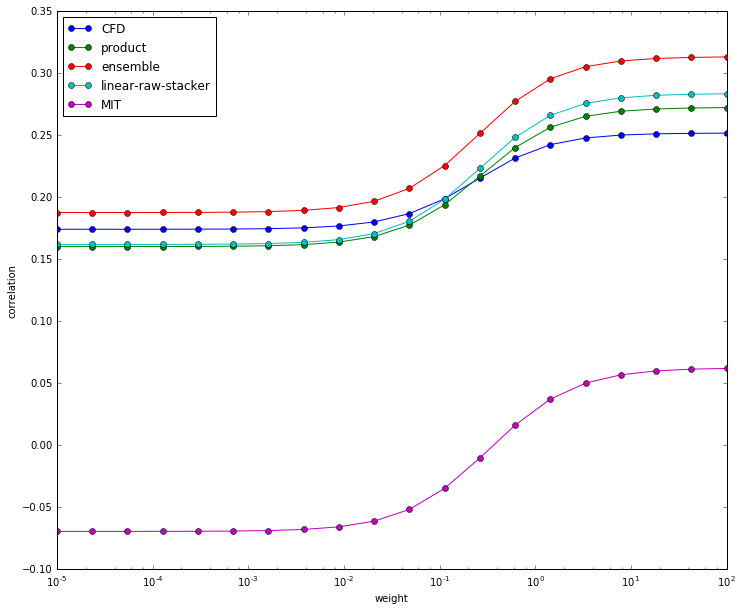

In [200]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')

In [190]:
features_concat = {}
for k in features.keys():
    features_concat[k] = np.concatenate((features_gecko[k], features[k]), axis=0)
y_concat = np.concatenate((y_gecko_rank, y_rank), axis=0)

In [198]:
kf = sklearn.cross_validation.KFold(y_rank.shape[0], n_folds=20)
preds = dict((m, np.zeros_like(y_rank)) for m in features.keys())

for i, split in enumerate(kf):
    train, test = split
    train += y_gecko_rank.shape[0]
    train = np.concatenate((np.arange(0, y_gecko_rank.shape[0]), train), axis=0)

                           
    test += y_gecko_rank.shape[0]
    for method in features.keys():
        final_model = elevation.aggregation.train_model(features_concat[method][train], y_concat[train])
        preds[method][test-y_gecko_rank.shape[0]] = final_model.predict(features_concat[method][test])
    print i

4550
9143
0
4550
9143
1
4550
9143
2
4550
9143
3
4550
9143
4
4550
9143
5
4550
9143
6
4550
9143
7
4550
9143
8
4550
9143
9
4551
9144
10
4551
9144
11
4551
9144
12
4551
9144
13
4551
9144
14
4551
9144
15
4551
9144
16
4551
9144
17
4551
9144
18
4551
9144
19


CFD
product
ensemble
linear-raw-stacker
MIT


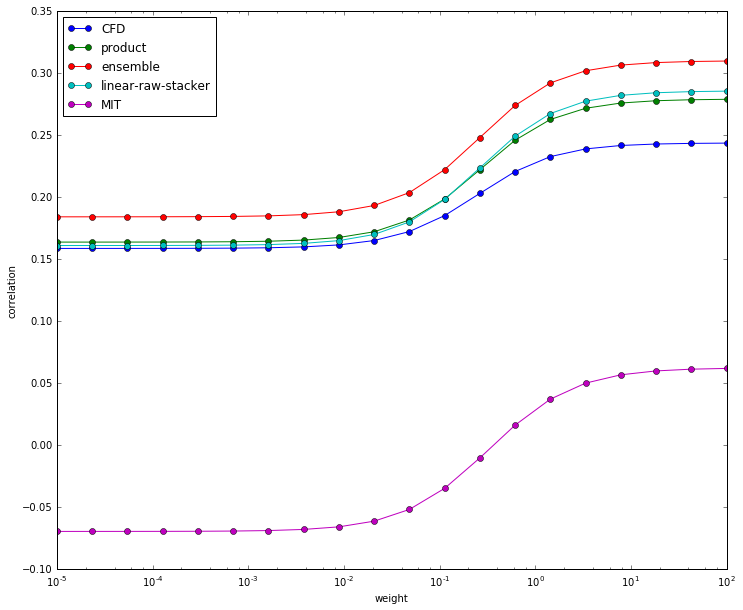

In [161]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, st.mstats.rankdata(truth)/float(len(truth)), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')

In [202]:
#y_gecko = np.array(truth_gecko)
#y_gecko_rank = st.mstats.rankdata(y_gecko)/float(len(y_gecko))
import copy
features_gecko_tmp = copy.deepcopy(features_gecko)
features_gecko_tmp['ensemble'] = np.concatenate((features_gecko['linear-raw-stacker'], features_gecko['CFD']), axis=1)

kf = sklearn.cross_validation.KFold(y_gecko_rank.shape[0], n_folds=20, shuffle=True)


preds_gecko = dict((m, np.zeros_like(y_gecko_rank)) for m in features_gecko_tmp.keys())

for i, split in enumerate(kf):
    train, test = split
    for method in features_gecko_tmp.keys():
        if method != 'MIT':
            feat = features_gecko_tmp[method]
            # final_model = train_big_model(feat[train], y_gecko[train]) 
            final_model = elevation.aggregation.train_model(feat[train], y_gecko_rank[train])
            # final_model.fit(feat[train], y_gecko[train])
            preds_gecko[method][test] = final_model.predict(feat[test])
        else:
            preds_gecko[method] = mean_gecko[method]
    print i

preds_gecko['MIT'] = mean_gecko['MIT']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [204]:
kf = sklearn.cross_validation.KFold(y_gecko_rank.shape[0], n_folds=20)
preds = dict((m, np.zeros_like(y_gecko_rank)) for m in features.keys())

for i, split in enumerate(kf):
    train, test = split
    train = np.concatenate((train, np.arange(y_gecko_rank.shape[0], y_concat.shape[0])), axis=0)
    print train.shape
    for method in features.keys():
        final_model = elevation.aggregation.train_model(features_concat[method][train], y_concat[train])
        preds[method][test-y_gecko_rank.shape[0]] = final_model.predict(features_concat[method][test])
    print i

(9153,)
0
(9153,)
1
(9153,)
2
(9153,)
3
(9153,)
4
(9153,)
5
(9153,)
6
(9153,)
7
(9153,)
8
(9153,)
9
(9153,)
10
(9153,)
11
(9153,)
12
(9154,)
13
(9154,)
14
(9154,)
15
(9154,)
16
(9154,)
17
(9154,)
18
(9154,)
19


CFD
MIT
product
linear-raw-stacker
ensemble


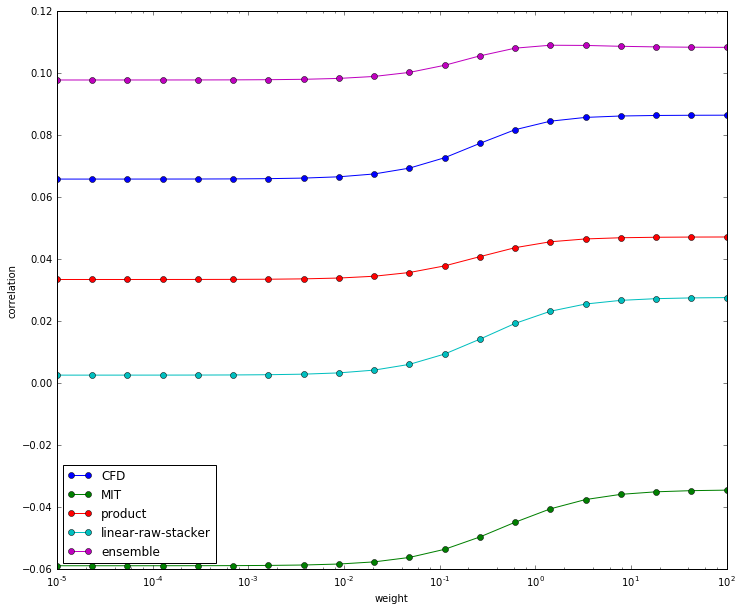

In [203]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds_gecko, st.mstats.rankdata(truth_gecko)/float(len(truth_gecko)), 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')

CFD
product
ensemble
linear-raw-stacker
MIT


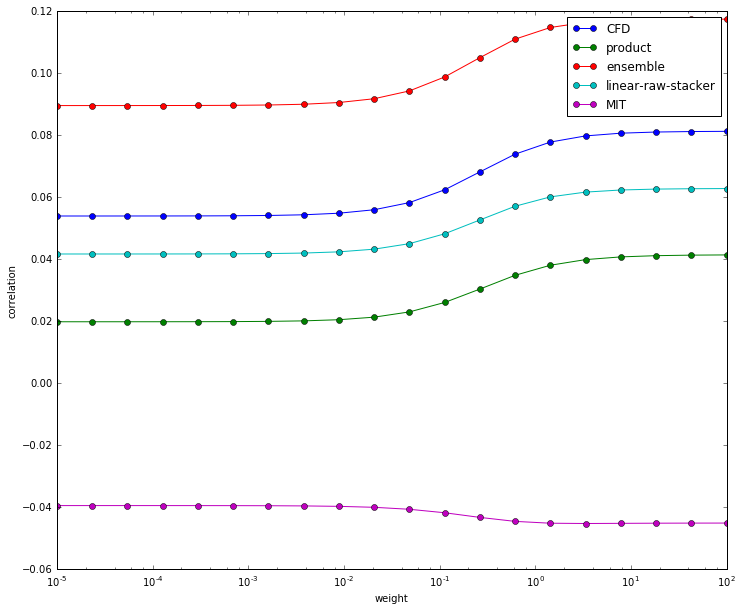

In [207]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, y_gecko_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')

In [162]:
mit_avana.shape

(4950, 17)

In [171]:
np.unique(mit_gecko[['Target Gene ID']].values).shape

KeyError: "['Target Gene ID'] not in index"

In [172]:
mit_gecko.columns

Index([u'offtarget_score', u'sgRNA measured value', u'sgRNA Sequence'], dtype='object')

In [180]:
num_off = []
for g in results[1].keys():
    num_off.append(len(results[1][g]))

In [182]:
np.mean(num_off)

16612.321294363257

In [183]:
20000*20000*500

200000000000